#  Packages

### Downloading packages 
#### Select and run just either one of them

In [ ]:
!pip3 install --upgrade pip
!pip3 install pandas
!pip3 install seaborn --force
!pip3 install matplotlib
!pip3 install sklearn
!pip3 install missingno

### Importing libraries

In [203]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.preprocessing import scale

### Reading files and setting variables

In [174]:
path, file, extension = '../../data/', 'Results for 141', '.csv'
df = pd.read_csv (os.path.join(path, file) + extension, sep = ',')

# ETL

### Renaming a column and changing axis order

In [175]:
df.insert(loc = 1, column = 'Overall Score', value = df['Overall'])
df.drop(['Overall'], axis=1, inplace=True)

### Reindexing columns

In [176]:
df = df.reindex(columns=[
    'Employee', 'Overall Score', 'EC2 (2)', 
    'S3 Arch (0.5)', 'S3 Access (0.5)', 'S3 Classes (0.5)', 'S3 DR (0.5)', 'IAM (1)', 'Networking (2)', 'Net. App. Reliability (2)', 
    'Configuration drift', 'Count and ForEach', 'Environment', 'Organizing resources', 'Process', 'Secrets and States', 'Sensitive information', 'TF Best practices', 'Values to terraform', 
    'Architecture: Auto Scaling', 'Architecture: Control Plane', 'Core Concepts', 'Services & Networking: Ingress', 'Services & Networking: Service', 'Workload Management'
])

### Re-group of columns for better management

In [177]:
df.columns = [
    '[Candidate] ID', '[Candidate] Overall',
    '[AWS] EC2', '[AWS] S3: Arch', '[AWS] S3: Access', '[AWS] S3: Clasess', '[AWS] S3: DR', '[AWS] IAM', '[AWS] Networking', '[AWS] Net. App. Reliability',
    '[TF] Configuration drifts', '[TF] Use of count & for_each', '[TF] Environments', '[TF] Managing resources', '[TF] Process', '[TF] Secrets and States', '[TF] Sensitive information', '[TF] Best practices', '[TF] Managing values', 
    '[K8] Architecture: Auto Scaling', '[K8] Architecture: Control Plane', '[K8] Core Concepts', '[K8] Services & Networking: Ingress', '[K8] Services & Networking: Service', '[K8] Workload Management'
]

### Adding hired/no hired labels

In [178]:
df['Hired'] = ['Yes' if x >= 50 else 'No' for x in df['[Candidate] Overall']]
df.insert(loc = 1, column = '[Candidate] Hired', value = df['Hired'])
df.drop(['Hired'], axis=1, inplace=True)

# Functions definitions

### Disclaimer

In [179]:
'''
Most of these functions have been taken from the 'EDA_Attrition_Dataset.ipynb' file, so all coding credits go to the respective author.
'''

"\nMost of these functions have been taken from the 'EDA_Attrition_Dataset.ipynb' file, so all coding credits go to the respective author.\n"

### Generate pie chart

In [180]:
def generate_pie_chart(df, feature, name):
    # Detecting quantities of each class
    label_yes = sum(df[feature] == "Yes")
    label_no  = sum(df[feature] == "No")

    # Defining labels
    size_of_groups = [label_no, label_yes]
    names          = ["No {}" .format(name), "{}" .format(name)]

    # Generating outer cirle plot
    plt.figure(figsize=(5, 5))
    plt.title("Number of observations per class of the {} variable" .format (name))
    plt.pie(size_of_groups, labels=names)

    # Adding a circle at the center to create the pie
    my_circle = plt.Circle((0,0), 0.7, color='white')
    p         = plt.gcf()
    p.gca().add_artist(my_circle)
    plt.show()

### Generate barplot

In [181]:
def generate_barplot(df, feature, order=None):
    # Replacing missing values with a string
    new_df = df.copy()
    new_df[feature] = df[feature].fillna('Missing')

    # Generating bar-plot chart
    plt.figure(figsize=(6, 5))
    ax = sns.countplot(x=feature, data=new_df, edgecolor='k', order=order)
    plt.title("Number of observations according to feature {0}".format(feature))
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

### Generate boxplots

In [217]:
def generate_boxplots(df, columns = df.columns[0]):
    # Obtaining numerical features
    new_df = df.select_dtypes(include="number")
    # new_df.drop(columns=columns, inplace=True)
    new_df_cols = new_df.columns
    std_cols = []

    # Standardizing features
    for feature in new_df_cols:
        new_df["{0}_scaled".format(feature)] = scale(new_df[feature], with_mean=True, with_std=True)
        std_cols.append("{0}_scaled".format(feature))

    # Generating box-plot of original features
    f, axes = plt.subplots(2, 1, figsize=(15, 10))
    plt.axes(axes[0])
    sns.boxplot(x="variable", y="value", data=pd.melt(new_df[new_df_cols]), orient = 'v', width = 0.5, linewidth = 1.2)
    plt.title("Box plot de features numéricas sin estandarizar")
    plt.xticks([])
    plt.grid()

    # Generando box-plot de las features estandarizadas
    plt.axes(axes[1])
    sns.boxplot(x="variable", y="value", data=pd.melt(new_df[std_cols]), orient = 'v', width = 0.5)
    plt.title("Box plot de features numéricas estandarizadas")
    plt.xticks(rotation=90)
    plt.grid()

# EDA

## Functions executions

### Generate pie chart

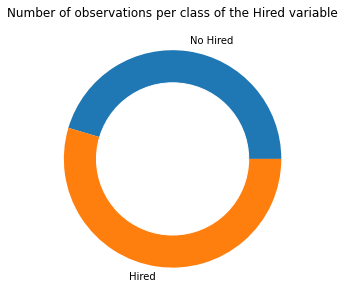

In [183]:
generate_pie_chart (df, '[Candidate] Hired', 'Hired')

### Generate barplot

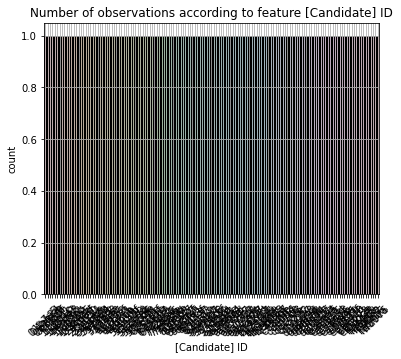

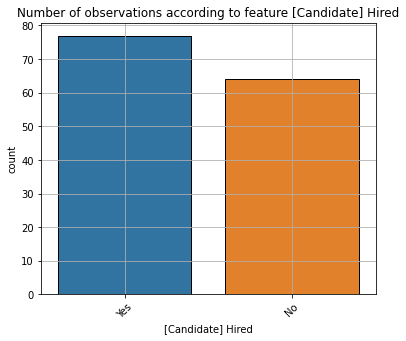

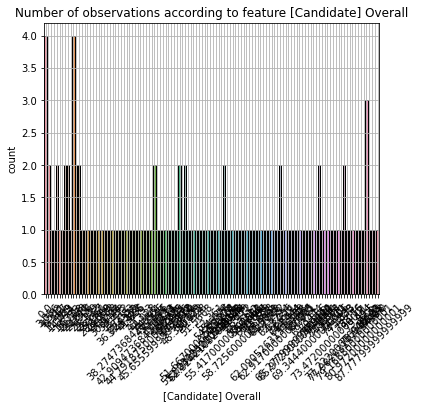

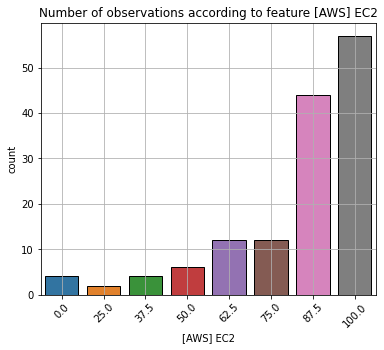

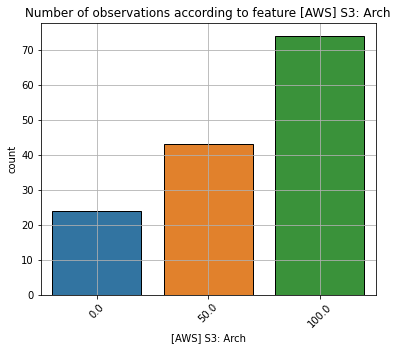

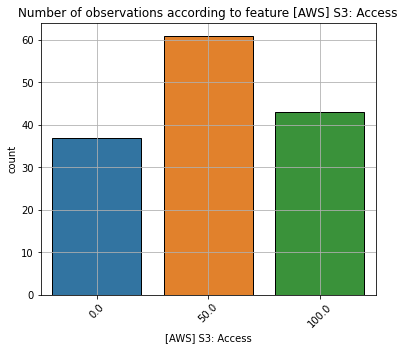

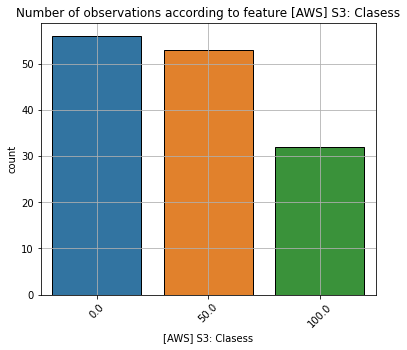

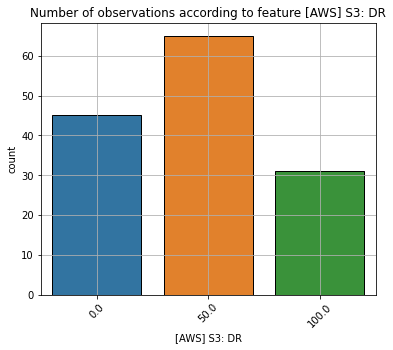

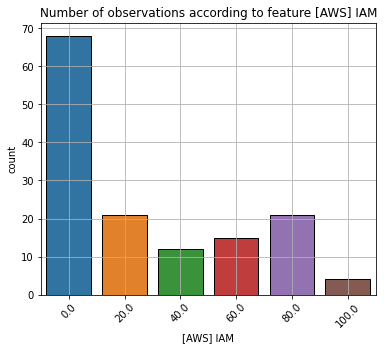

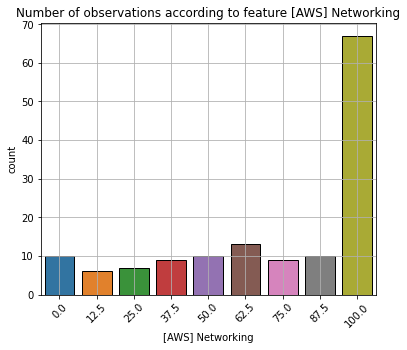

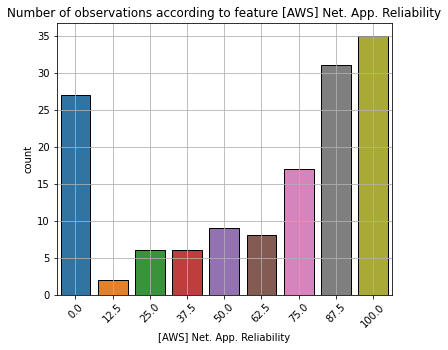

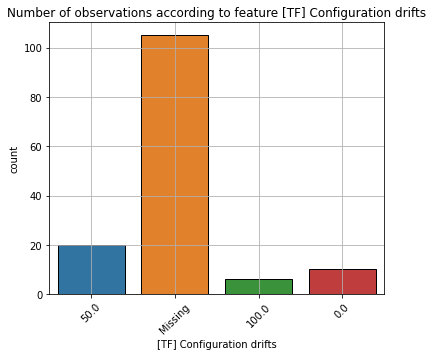

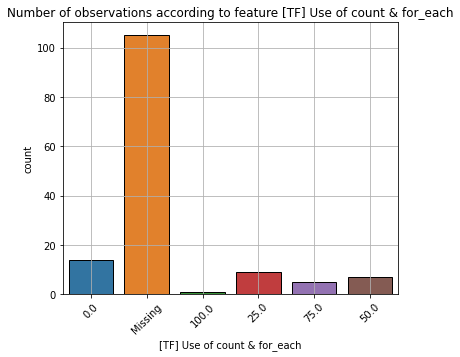

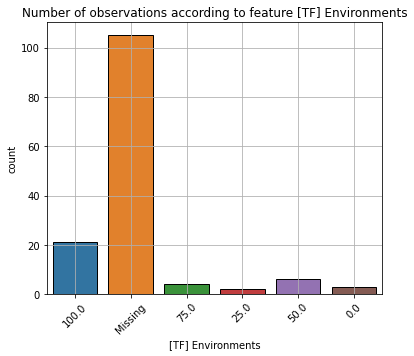

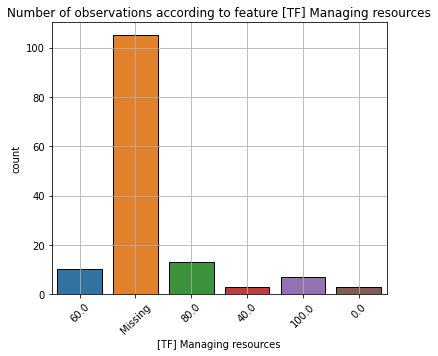

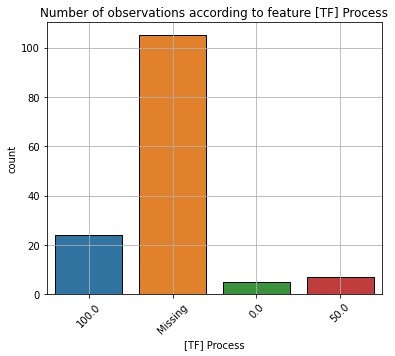

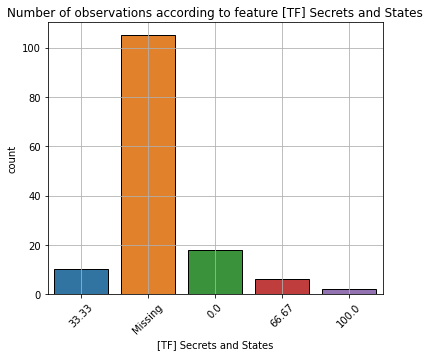

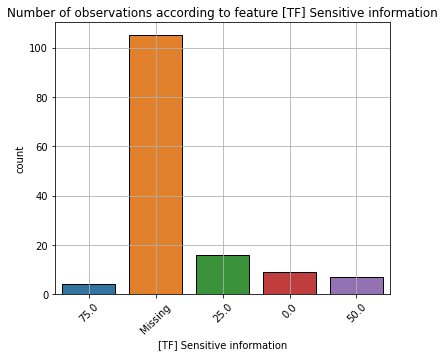

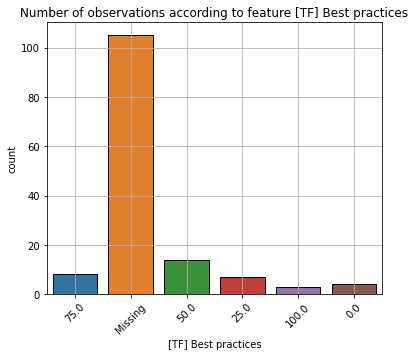

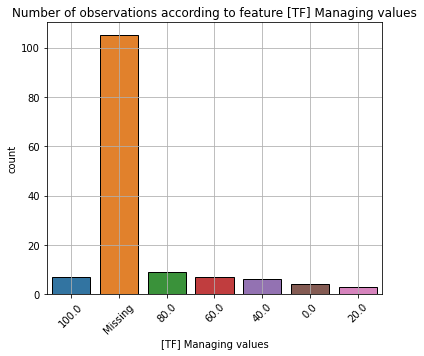

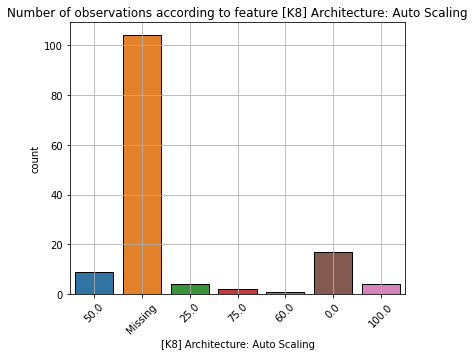

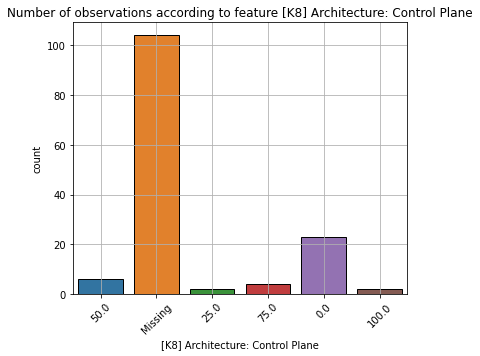

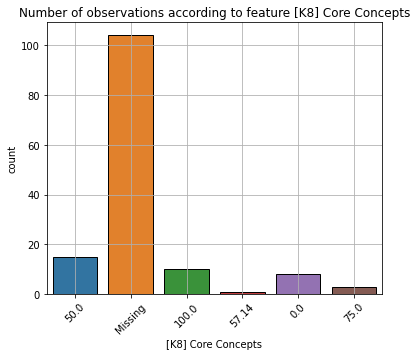

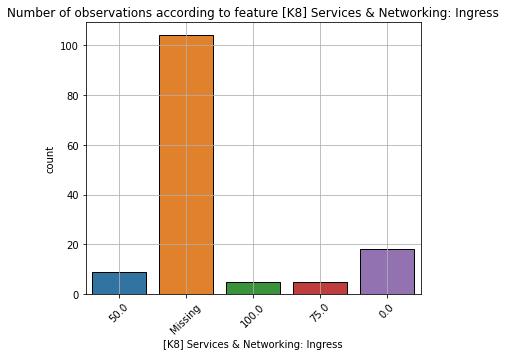

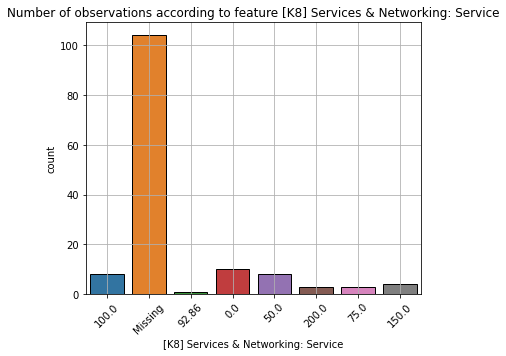

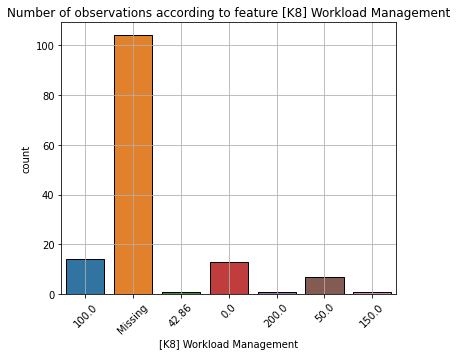

In [184]:
for i in range (0, df.shape[1]):
    generate_barplot (df, df.columns[i] )

### Generate boxplots

/var/folders/gd/xh4p1yxj22l01dr06998m3hw0000gp/T/ipykernel_49424/2045861405.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df["{0}_scaled".format(feature)] = scale(new_df[feature], with_mean=True, with_std=True)


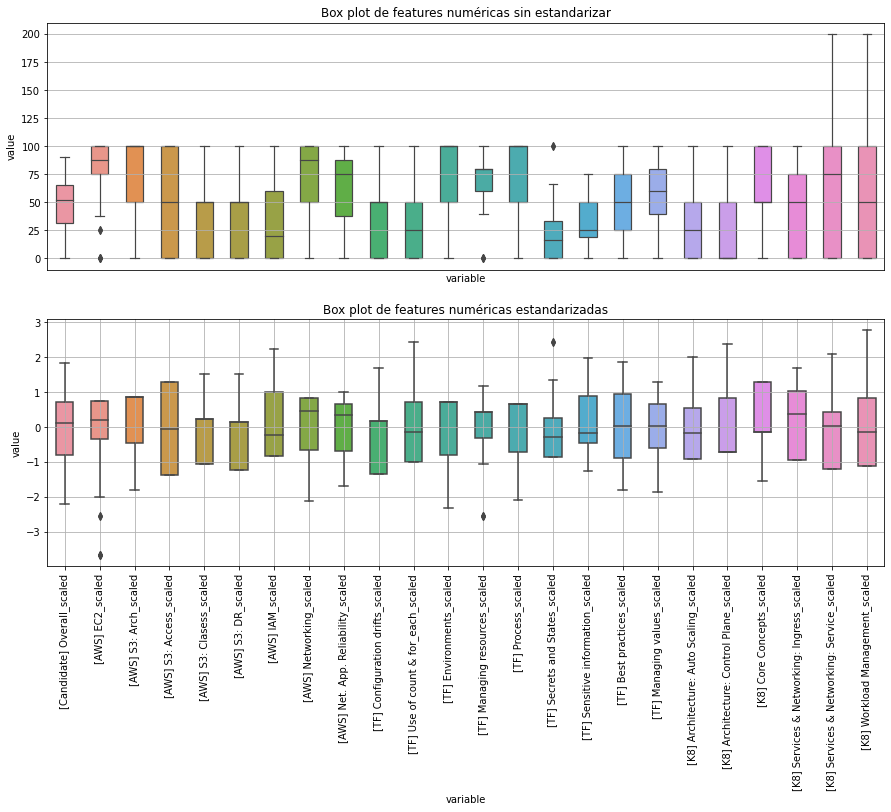

In [218]:
generate_boxplots (df)